In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/DLMI_challenge')

Mounted at /content/drive


In [2]:
!pip install torchmetrics pytorch_optimizer torchstain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import h5py
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchmetrics
import timm
import pytorch_optimizer

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() # for Nvidia GPU users
                      else 'mps' if torch.backends.mps.is_available() # for MacOS MPS users
                      else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
TRAIN_IMAGES_PATH = 'data/train.h5'
VAL_IMAGES_PATH = 'data/val.h5'
TEST_IMAGES_PATH = 'data/test.h5'
SEED = 0

In [6]:
torch.random.manual_seed(SEED)
random.seed(SEED)

# DLMI CHALLENGE : Data preparation

In this notebook, we build upon the preprocessing strategy defined in data_analysis.ipynb. Our objective is to mitigate the influence of center-specific variations in the classification of infected tissues.

## Loading and precomputing of the data

In this challenge we have used a pretrained backbone that we will finetune during training. As the model we will use is huge, we will first do a forward pass on the model to store the features exctracted.

In [7]:
class DANN_Dataset(Dataset):
    """New Dataset which returns the image, label and the center (domain)"""
    def __init__(self, dataset_path, preprocessing, mode):
        super(DANN_Dataset, self).__init__()
        self.dataset_path = dataset_path
        self.preprocessing = preprocessing
        self.mode = mode
        with h5py.File(self.dataset_path, 'r') as hdf:
            self.image_ids = list(hdf.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        with h5py.File(self.dataset_path, 'r') as hdf:
            img = torch.tensor(np.array(hdf.get(img_id).get('img')))
            # Pour le training, on retourne label et centre (domaine)
            if self.mode == 'train':
                label = torch.tensor(np.array(hdf.get(img_id).get('label')), dtype=torch.float32)
                center = torch.tensor(np.array(hdf.get(img_id).get('metadata'))[0], dtype=torch.long)
            else:
                label = None
                center = None
        return self.preprocessing(img).float(), label, center

def precompute(dataloader, model, device, need_features = False):
    xs, ys, centers = [], [], []
    model.eval()
    with torch.no_grad():
        for x, y, center in tqdm(dataloader, leave=False):
            #
            x = x.to(device)
            if need_features:
                embeddings = model.forward_features(x) # to output also CLS tokens
            else :
                embeddings = model(x)
            xs.append(embeddings.cpu())
            ys.append(y)
            centers.append(center)


    xs = torch.cat(xs).cpu()
    ys = torch.cat(ys).cpu()
    centers = torch.cat(centers).cpu()

    return xs, ys, centers

class PrecomputedDataset(Dataset):
    def __init__(self, features, labels, centers):
        super(PrecomputedDataset, self).__init__()
        self.features = features
        self.labels = labels.unsqueeze(-1)
        self.centers = centers

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx].float(), self.centers[idx].float()

### Optionnal pre-processing

In [8]:
preprocessing = T.Compose([
    T.ToPILImage(),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#### Stain normalization

We will build upon the preprocessing strategy defined in `data_analysis.ipynb`. Our objective is to mitigate the influence of center-specific variations in the classification of infected tissues. We aim to achieve this by combining robust preprocessing with a well-designed training pipeline, allowing the model to focus on biologically meaningful features rather than artifacts related to data acquisition.

In [9]:
with h5py.File(TRAIN_IMAGES_PATH, 'r') as hdf:
    records = []
    for img_idx in hdf.keys():
        label = int(np.array(hdf.get(img_idx).get('label')))
        center = int(np.array(hdf.get(img_idx).get('metadata'))[0])

        records.append({'index': img_idx, 'center': center, 'label': label})

train_dataframe = pd.DataFrame(records) # We store the idx of each img with metadatas.

In [10]:
from src.preprocessing import StainNormalize

import torchvision.transforms.functional as TF
from torchvision.transforms import v2
from torch.utils.data import random_split

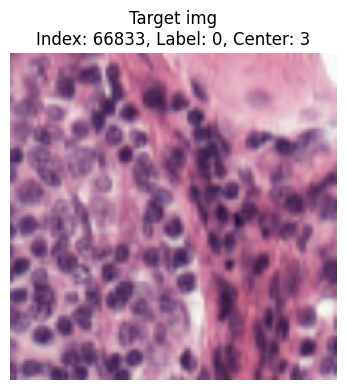

In [11]:
# We choose a target image to fit the stain normalizer
# This image will be used to normalize all other images in the dataset
target_idx = train_dataframe[train_dataframe['center'] == 3].sample(1, random_state=SEED+15)['index'].values[0]

# Open the HDF5 file in read mode
hdf = h5py.File(TRAIN_IMAGES_PATH, 'r', swmr=True)

# Define the transform for the target image to matches the input size of the model
target_transform = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((224,224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# Read the target image from the HDF5 file, apply the transform and multiply the image by 255.0
target_img = torch.from_numpy(hdf[target_idx]['img'][()]).float()
target_img = target_transform(target_img)*255.0

# display of the target image selected for stain normalization
fig, axes = plt.subplots(1, 1, figsize=(8, 4))

label = hdf[target_idx]['label'][()]
center = hdf[target_idx]['metadata'][()][0]

axes.imshow(TF.to_pil_image(target_img/255.0))
axes.set_title(f"Target img\nIndex: {target_idx}, Label: {label}, Center: {center}")
axes.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Setup the stain normalizer with the target image
stain_normalizer = StainNormalize(target_image_tensor=target_img, backend='torch', method='reinhard')

stain_transform = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    stain_normalizer
])

### Construction of the datasets

In [13]:
def save_precomputed_dataset(dataset, filename):
    """Save a PrecomputedDataset in a HDF5 file.
    Args :
    dataset : PrecomputedDataset class
    filename : file path
    """
    with h5py.File(filename, 'w') as h5f:
        h5f.create_dataset('features', data=dataset.features.numpy())
        h5f.create_dataset('labels', data=dataset.labels.numpy())
        h5f.create_dataset('centers', data=dataset.centers.numpy())


def load_precomputed_dataset(filename):
    """Load a PrecomputedDataset from a HDF5 file.
    Args :
    filename : file path
    """
    with h5py.File(filename, 'r') as h5f:
        features = torch.tensor(h5f['features'][:])
        labels = torch.tensor(h5f['labels'][:])
        centers = torch.tensor(h5f['centers'][:])
    return PrecomputedDataset(features, labels,centers)


#### No Stain + full backbone

In [14]:
train_dataset = DANN_Dataset(TRAIN_IMAGES_PATH, preprocessing, 'train')
val_dataset = DANN_Dataset(VAL_IMAGES_PATH, preprocessing, 'train')

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

To do the precomputing stage, we will use a ViT based model, pre-trained on histopathological images, as a backbone.

In [17]:
# Loading our feature extractor
backbone = timm.create_model(
  model_name="hf-hub:1aurent/vit_base_patch16_224.owkin_pancancer",
  pretrained=True,
  num_classes = 384
)
# we save the head so during testing we will be able to recreate the backbone used in training
torch.save(backbone.head.state_dict(), 'data/precomputed_datasets/owk_backbone_head.pth')

backbone.eval().to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [18]:
train = PrecomputedDataset(*precompute(train_dataloader,backbone, device))
save_precomputed_dataset(train, 'data/precomputed_datasets/train_owk_full_backbone.h5')

  0%|          | 0/782 [00:00<?, ?it/s]

In [19]:
val = PrecomputedDataset(*precompute(val_dataloader,backbone, device))
save_precomputed_dataset(val, 'data/precomputed_datasets/val_owk_full_backbone.h5')

  0%|          | 0/273 [00:00<?, ?it/s]

#### Stain + full backbone

In [20]:
train_dataset = DANN_Dataset(TRAIN_IMAGES_PATH, stain_transform, 'train')
val_dataset = DANN_Dataset(VAL_IMAGES_PATH, stain_transform, 'train')

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

# Loading our feature extractor
backbone = timm.create_model(
  model_name="hf-hub:1aurent/vit_base_patch16_224.owkin_pancancer",
  pretrained=True,
  num_classes = 384
)
torch.save(backbone.head.state_dict(), 'data/precomputed_datasets/owk_backbone_head_stain.pth')

backbone.eval().to(device)

train = PrecomputedDataset(*precompute(train_dataloader,backbone, device))
save_precomputed_dataset(train, 'data/precomputed_datasets/train_owk_stain_full_backbone.h5')

val = PrecomputedDataset(*precompute(val_dataloader,backbone, device))
save_precomputed_dataset(val, 'data/precomputed_datasets/val_owk_stain_full_backbone.h5')

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

#### No stain + backbone without last linear layer

In [21]:
train_dataset = DANN_Dataset(TRAIN_IMAGES_PATH, preprocessing, 'train')
val_dataset = DANN_Dataset(VAL_IMAGES_PATH, preprocessing, 'train')

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

# Loading our feature extractor
backbone = timm.create_model(
  model_name="hf-hub:1aurent/vit_base_patch16_224.owkin_pancancer",
  pretrained=True
)

backbone.eval().to(device)

train = PrecomputedDataset(*precompute(train_dataloader,backbone, device))
save_precomputed_dataset(train, 'data/precomputed_datasets/train_owk_backbone_without_head.h5')

val = PrecomputedDataset(*precompute(val_dataloader,backbone, device))
save_precomputed_dataset(val, 'data/precomputed_datasets/val_owk_backbone_without_head.h5')

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

#### Stain + backbone without last linear layer

In [22]:
train_dataset = DANN_Dataset(TRAIN_IMAGES_PATH, stain_transform, 'train')
val_dataset = DANN_Dataset(VAL_IMAGES_PATH, stain_transform, 'train')

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

# Loading our feature extractor
backbone = timm.create_model(
  model_name="hf-hub:1aurent/vit_base_patch16_224.owkin_pancancer",
  pretrained=True,
  num_classes = 384
)

backbone.eval().to(device)

train = PrecomputedDataset(*precompute(train_dataloader,backbone, device))
save_precomputed_dataset(train, 'data/precomputed_datasets/train_owk_stain_backbone_without_head.h5')

val = PrecomputedDataset(*precompute(val_dataloader,backbone, device))
save_precomputed_dataset(val, 'data/precomputed_datasets/val_owk_stain_backbone_without_head.h5')

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]